# Loading Dataset

In [ ]:
!gdown --id 1rkiH9BJ3tvJrY4D22Htsu80R1mDMqrRU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rkiH9BJ3tvJrY4D22Htsu80R1mDMqrRU
To: /content/re-bert_featured_graph.p
100% 12.2M/12.2M [00:00<00:00, 150MB/s]


In [ ]:
import pickle
import networkx as nx

G = pickle.load( open( "re-bert_featured_graph.p", "rb" ) )
G

In [ ]:
for node in G.nodes(data=True):
  print(node)

In [ ]:
nx.number_connected_components(G)

# Loading data into StellarGraph from NetworkX


In [ ]:
!pip install stellargraph

In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets

In [ ]:
from stellargraph import StellarGraph
G = StellarGraph.from_networkx(G,node_features='features')
G

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 5536, Edges: 10499

 Node types:
  default: [5536]
    Features: float32 vector, length 512
    Edge types: default-default->default

 Edge types:
    default-default->default: [10499]
        Weights: all 1 (default)
        Features: none


# SEED!

In [ ]:
EXPERIMENTAL_SEED=42

# Loop Experimental

In [ ]:
def gcn_experimental_loop(EXPERIMENTAL_SEED,P_FRAC):

  # Define an edge splitter on the original graph G:
  edge_splitter_test = EdgeSplitter(G)

  # Randomly sample a fraction p=P_FRAC of all positive links, and same number of negative links, from G, and obtain the
  # reduced graph G_test with the sampled links removed:
  G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
      p=P_FRAC, method="global", keep_connected=True,seed=EXPERIMENTAL_SEED
  )

  # Define an edge splitter on the reduced graph G_test:
  edge_splitter_train = EdgeSplitter(G_test)

  # Randomly sample a fraction p=P_FRAC of all positive links, and same number of negative links, from G_test, and obtain the
  # reduced graph G_train with the sampled links removed:
  G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
      p=P_FRAC, method="global", keep_connected=True,seed=EXPERIMENTAL_SEED
  )

  train_gen = FullBatchLinkGenerator(G_train, method="gcn")
  train_flow = train_gen.flow(edge_ids_train, edge_labels_train)


  test_gen = FullBatchLinkGenerator(G_test, method="gcn")
  test_flow = train_gen.flow(edge_ids_test, edge_labels_test)
  print('Test size: ',G_test.number_of_nodes())

  gcn = GCN(
      layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
  )

  x_inp, x_out = gcn.in_out_tensors()

  prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

  prediction = keras.layers.Reshape((-1,))(prediction)

  model = keras.Model(inputs=x_inp, outputs=prediction)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.01),
      loss=keras.losses.binary_crossentropy,
      metrics=[keras.metrics.BinaryAccuracy()],
  )

  init_train_metrics = model.evaluate(train_flow)
  init_test_metrics = model.evaluate(test_flow)

  print("\nTrain Set Metrics of the initial (untrained) model:")
  for name, val in zip(model.metrics_names, init_train_metrics):
      print("\t{}: {:0.4f}".format(name, val))

  print("\nTest Set Metrics of the initial (untrained) model:")
  for name, val in zip(model.metrics_names, init_test_metrics):
      print("\t{}: {:0.4f}".format(name, val))

  history = model.fit(
      train_flow, epochs=50, validation_data=test_flow, verbose=2, shuffle=False
  )

  train_metrics = model.evaluate(train_flow)
  test_metrics = model.evaluate(test_flow)

  # print("\nTrain Set Metrics of the trained model:")
  # for name, val in zip(model.metrics_names, train_metrics):
  #     print("\t{}: {:0.4f}".format(name, val))

  print("\nTest Set Metrics of the trained model:")
  L = []
  for name, val in zip(model.metrics_names, test_metrics):
      print(name,val,len(edge_ids_train)/2,len(edge_ids_test)/2,EXPERIMENTAL_SEED,P_FRAC)
      L.append([name,val,len(edge_ids_train)/2,len(edge_ids_test)/2,EXPERIMENTAL_SEED,P_FRAC])

  return L

In [ ]:
L = []
for seed_ in [1,2,3,4,5,6,7,8,9,10]:
  for p_frac in [0.05,0.1,0.15,0.2,0.25,0.3]:
    results = gcn_experimental_loop(seed_,p_frac)
    L.append(results[1])

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 - 0s - loss: 0.5221 - binary_accuracy: 0.8143 - val_loss: 0.5275 - val_binary_accuracy: 0.8111 - 84ms/epoch - 84ms/step
Epoch 35/50
1/1 - 0s - loss: 0.5463 - binary_accuracy: 0.7922 - val_loss: 0.5143 - val_binary_accuracy: 0.8187 - 89ms/epoch - 89ms/step
Epoch 36/50
1/1 - 0s - loss: 0.5169 - binary_accuracy: 0.8042 - val_loss: 0.4887 - val_binary_accuracy: 0.8340 - 87ms/epoch - 87ms/step
Epoch 37/50
1/1 - 0s - loss: 0.5232 - binary_accuracy: 0.8112 - val_loss: 0.4680 - val_binary_accuracy: 0.8406 - 87ms/epoch - 87ms/step
Epoch 38/50
1/1 - 0s - loss: 0.4726 - binary_accuracy: 0.8213 - val_loss: 0.4688 - val_binary_accuracy: 0.8292 - 84ms/epoch - 84ms/step
Epoch 39/50
1/1 - 0s - loss: 0.4204 - binary_accuracy: 0.8283 - val_loss: 0.4414 - val_binary_accuracy: 0.8197 - 82ms/epoch - 82ms/step
Epoch 40/50
1/1 - 0s - loss: 0.4502 - binary_accuracy: 0.8102 - val_loss: 0.4394 - val_binary_accuracy: 0.7977 - 83ms/epoch - 83ms/step
E

In [ ]:
import pandas as pd
v = pd.DataFrame(L)
v

,0,1,2,3,4,5
0,binary_accuracy,0.829198,498.0,524.0,1,0.05
1,binary_accuracy,0.819828,945.0,1049.0,1,0.10
2,binary_accuracy,0.832910,1338.0,1574.0,1,0.15
3,binary_accuracy,0.790615,1680.0,2099.0,1,0.20
4,binary_accuracy,0.785442,1968.0,2624.0,1,0.25
5,binary_accuracy,0.776913,2205.0,3149.0,1,0.30
6,binary_accuracy,0.829198,498.0,524.0,2,0.05
7,binary_accuracy,0.815539,945.0,1049.0,2,0.10
8,binary_accuracy,0.790343,1338.0,1574.0,2,0.15
9,binary_accuracy,0.819438,1680.0,2099.0,2,0.20


In [ ]:
v.to_csv('gcn_with_ml.csv',index=False)

In [ ]:
len(edge_ids_train)/2

1680.0

# Training and Testing

In [ ]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.2 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.2, method="global", keep_connected=True,seed=EXPERIMENTAL_SEED
)

** Sampled 2099 positive and 2099 negative edges. **


In [ ]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.2 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.2, method="global", keep_connected=True,seed=EXPERIMENTAL_SEED
)


** Sampled 1680 positive and 1680 negative edges. **


# GCN MODEL

In [ ]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [ ]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()


In [ ]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [ ]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [ ]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


1/1 [==============================] - 0s 134ms/step - loss: 2.4868 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 2.4737
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 2.4868
	binary_accuracy: 0.5000


In [ ]:
history = model.fit(
    train_flow, epochs=50, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 5s - loss: 2.4006 - binary_accuracy: 0.5000 - val_loss: 0.9221 - val_binary_accuracy: 0.5736 - 5s/epoch - 5s/step
Epoch 2/50
1/1 - 0s - loss: 0.9195 - binary_accuracy: 0.5768 - val_loss: 0.4699 - val_binary_accuracy: 0.7811 - 82ms/epoch - 82ms/step
Epoch 3/50
1/1 - 0s - loss: 0.4644 - binary_accuracy: 0.7768 - val_loss: 1.1781 - val_binary_accuracy: 0.6332 - 77ms/epoch - 77ms/step
Epoch 4/50
1/1 - 0s - loss: 1.2292 - binary_accuracy: 0.6488 - val_loss: 1.1510 - val_binary_accuracy: 0.6339 - 85ms/epoch - 85ms/step
Epoch 5/50
1/1 - 0s - loss: 1.3091 - binary_accuracy: 0.6455 - val_loss: 0.7152 - val_binary_accuracy: 0.7275 - 86ms/epoch - 86ms/step
Epoch 6/50
1/1 - 0s - loss: 0.8040 - binary_accuracy: 0.7110 - val_loss: 0.5201 - val_binary_accuracy: 0.8042 - 92ms/epoch - 92ms/step
Epoch 7/50
1/1 - 0s - loss: 0.5306 - binary_accuracy: 0.7815 - val_loss: 0.4587 - val_binary_accuracy: 0.8085 - 81ms/epoch - 81ms/step
Epoch 8/50
1/1 - 0s - loss: 0.4746 - binary_accuracy: 0.791

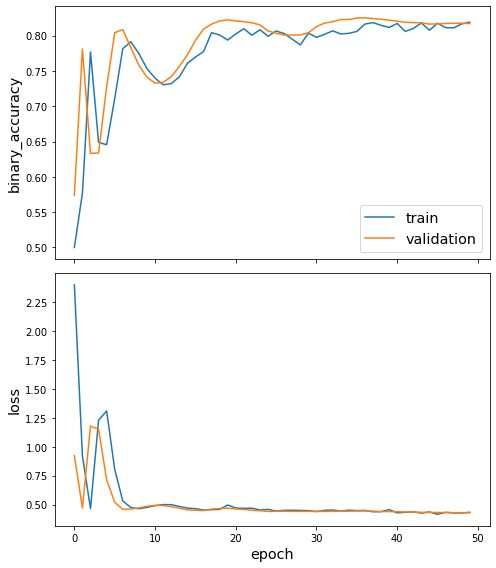

In [ ]:
sg.utils.plot_history(history)


In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 59ms/step - loss: 0.4293 - binary_accuracy: 0.8171

Train Set Metrics of the trained model:
	loss: 0.4095
	binary_accuracy: 0.8318

Test Set Metrics of the trained model:
	loss: 0.4293
	binary_accuracy: 0.8171


In [ ]:
for layer in model.layers:
  print(layer)

In [ ]:
embedding_generator = keras.Model(inputs=model.input, outputs=model.layers[7].output)

In [ ]:
embedding_generator.predict(test_flow)[0]

array([[0.02329788, 0.        , 0.        , ..., 0.        , 0.        ,
        0.509239  ],
       [0.02009656, 0.        , 0.        , ..., 0.        , 0.        ,
        0.3549816 ],
       [0.        , 0.00774993, 0.        , ..., 0.        , 0.        ,
        0.6110294 ],
       ...,
       [0.031451  , 0.03096072, 0.        , ..., 0.        , 0.        ,
        0.64562935],
       [0.01587136, 0.03184835, 0.        , ..., 0.        , 0.        ,
        0.28366488],
       [0.0262873 , 0.01555748, 0.        , ..., 0.        , 0.        ,
        0.43047425]], dtype=float32)

In [ ]:
X_aspectos_treino = [features_embedding]

In [ ]:
X_aspectos_extraidos = [features_embedding]

In [ ]:
para cada aspect_embedding em X_aspectos_Extradios:
  para cada aspecto_embedding_treino in X_aspectos_treinoÇ
    sim = cosseno(aspect_embedding,aspecto_embedding_treino)
    if sim > limiar: EH ASPECTO